# **OPTIMIZING LOAN APPROVALS**
### **A Data-Driven Model For Assessing Installment-to-Income Risk**

*A DSCI 550 Group Project (Spring 2024)*

**Created by**
- Jinwen “Eddie” Zhao
- Jackson Crawford
- Cameron Ela
- Ravish Kamath

## Introduction

**Objective**
- Improve loan default for peer-to-peer loans (LendingClub)

**Background**
- Current models underperforming negatively affecting loan decision-making. Non-gurantee of future results. (Cornell 2020 Study)

**Task**
- Develop an advanced model to predict default probabilities including both quantitative and behaviorial factors.

**Goal**
- Refine loan approval criteria to manage risk effectively.



## Question and Hypothesis

***Does a higher installment-to-income ratio increase the likelihood of loan defaults on the LendingCLub platform?***

**Hypothesis**:
- The ratio of loan installments to annual income is directly associated with an increased risk of loan default, suggesting that borrowers whose loan repayments constitute a larger fraction of their income are more prone to financial distress, leading to a higher probability of default.

## Dataset and Libraries

In [169]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### FOR GOOGLE COLLAB CONNECTION
# from google.colab import drive
# from google.colab import drive
# drive.mount('/content/drive')

In [170]:
# # Reading the loan_light.csv file
#
# loan_light = pd.read_csv("/content/drive/MyDrive/DSCI550_project/loan_light.csv")
# loan = loan_light   # Make a hard copy of the database called "loan" so it doesn't get messed up afterward
# columns = loan.columns
# loan.head()

In [171]:
loan_light = pd.read_csv("loan_light.csv")
# Make a hard copy of the database called "loan" so it doesn't get messed up afterward
loan = loan_light.copy()

loan_light.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
0,80000.0,Individual,6746.0,0.0,0.0,15.12,10,B,1.0,743.75,...,1.0,0.0,OWN,36,0.0,0.0,debt_consolidation,2016,1,principal
1,60000.0,Individual,13623.0,0.0,0.0,12.32,7,D,0.0,286.73,...,3.0,0.0,MORTGAGE,60,1.0,0.0,credit_card,2017,0,other
2,78000.0,Individual,11011.0,0.0,0.0,25.00,1,D,6.0,869.66,...,4.0,0.0,MORTGAGE,60,3.0,0.0,debt_consolidation,2015,0,analyst
3,62000.0,Individual,9679.0,0.0,0.0,22.32,9,D,7.0,713.96,...,2.0,0.0,RENT,36,4.0,0.0,debt_consolidation,2017,1,other
4,49000.0,Individual,4925.0,0.0,0.0,32.43,10,D,0.0,366.51,...,4.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,1,driver


## Description of Dataset:
The dataset was obtained through a statistics professor at York University, who provided multiple real-life datasets ranging from bank data to real-estate datasets. We specifically chose a bank loan dataset. We are looking at 5000 loan requests issued by a bank, with each data point having 21 features. The table contains vital information to determine if a bank should loan to clients, such as whether they have defaulted before, how much annual income they had in previous years, how much they are borrowing, their jobs, and the rating of the loan. The dataset is already cleaned and easily interpreted by a human viewer. It has few ambiguous entries and empty values. After a bit of cleaning, the dataset will be ready for Python machine learning.

The following spreadsheet will be explaining what does each parameter mean. Note that we are interested in the loan_default value.

In [172]:
# loan_param = pd.read_excel('/content/drive/MyDrive/DSCI550_project/loan_param.xlsx')
# loan_param.style.set_properties(subset=['Description'], **{'width': '1000px'})

In [173]:
loan_param = pd.read_excel('loan_param.xlsx')
loan_param.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


## Data Cleaning

(The data is already pretty clean lol tho so if any of you guys wanna elaborate on it then feel free.):

## Exploring the Data

### EDA steps:
- Variable Identification
- Univariate analysis,
- Bi-variate analysis
- Missing value treatment (no missing values, skip),
- Outlier treatment (WIP),
- Variable transformation/creation

### Variable Identification


**Assigning variables to be categorical, ordinal, continuous and date:**

***Target Variable:***
- loan_default

***Categorical Variables:***
- application_type
- home_ownership
    - Behavioural factor
- purpose
- job
    - Behavioural factor

***Ordinal Variable:***
- grade
- emp_length
  - Behavioural factor

***Discrete Variables:***
- chargeoff_within_12_mths
- delinq_2yrs
- inq_last_12m
- num_actv_bc_tl
- pub_rec_bankruptcies
- term
    - (36 or 60 month term)
- mort_acc
- num_tl_90g_dpd_24m

***Datetime Object:***
- year

***Continous Variables:***
- annual_inc
- avg_cur_bal
- dti
- installment
- loan_amnt

In [174]:
str_cats = ['application_type', 'home_ownership', 'purpose', 'job']
for cols in str_cats:
    loan[cols] = loan[cols].astype('category')

int_cats = ['chargeoff_within_12_mths', 'delinq_2yrs', 'inq_last_12m', 'num_actv_bc_tl',
            'pub_rec_bankruptcies', 'term', 'mort_acc', 'num_tl_90g_dpd_24m']
for cols in int_cats:
    loan[cols] = loan[cols].astype('int')

loan['loan_amnt'] = loan['loan_amnt'].astype('float')

In [175]:
def convert_to_ordinal(char):
    if char.upper() not in 'ABCDEFG':
        return None  # Return None for characters other than A to G
    return ord('G') - ord(char.upper()) + 1  # Convert the character to its reversed ordinal value

loan['grade'] = loan['grade'].apply(lambda x: convert_to_ordinal(x))

# Convert Employment into categories with similar timeframe experience
emp_len_map = {0: "< 1 year",
               1: '1 - 2 years',
               2: '1 - 2 years',
               3: '3 - 5 years',
               4: '3 - 5 years',
               5: '3 - 5 years',
               6: '6 - 9 years',
               7: '6 - 9 years',
               8: '6 - 9 years',
               9: '6 - 9 years',
               10: '10+ years'}
loan['emp_length_cat'] = loan['emp_length'].map(emp_len_map).astype('category')

emp_length_unique_list = [item for index, item in enumerate(emp_len_map.values()) if item not in list(emp_len_map.values())[:index]]

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories= [emp_length_unique_list])
loan['emp_length'] = enc.fit_transform(loan[['emp_length_cat']])
loan['emp_length'] = loan['emp_length'].astype('int')

# Remove to datetime
loan = loan.drop('year', axis= 1)

In [176]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   annual_inc                5000 non-null   float64 
 1   application_type          5000 non-null   category
 2   avg_cur_bal               5000 non-null   float64 
 3   chargeoff_within_12_mths  5000 non-null   int64   
 4   delinq_2yrs               5000 non-null   int64   
 5   dti                       5000 non-null   float64 
 6   emp_length                5000 non-null   int64   
 7   grade                     5000 non-null   int64   
 8   inq_last_12m              5000 non-null   int64   
 9   installment               5000 non-null   float64 
 10  loan_amnt                 5000 non-null   float64 
 11  num_actv_bc_tl            5000 non-null   int64   
 12  pub_rec_bankruptcies      5000 non-null   int64   
 13  home_ownership            5000 non-null   catego

In [177]:
# Showing the average, spread, and the range of continuous variable.
loan.describe().applymap('{:,.2f}'.format)

,annual_inc,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,loan_amnt,num_actv_bc_tl,pub_rec_bankruptcies,term,mort_acc,num_tl_90g_dpd_24m,loan_default
count,"5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00"
mean,"79,301.50","13,687.34",0.01,0.32,18.06,2.64,5.20,2.38,447.17,"14,577.06",3.58,0.15,41.73,1.49,0.08,0.23
std,"46,568.05","16,501.18",0.11,0.83,8.75,1.20,1.30,2.45,282.05,"9,234.44",2.33,0.40,10.23,1.76,0.36,0.42
min,"12,000.00",0.00,0.00,0.00,0.00,1.00,1.00,0.00,30.12,"1,000.00",0.00,0.00,36.00,0.00,0.00,0.00
25%,"49,500.00","3,028.75",0.00,0.00,11.49,2.00,4.00,1.00,240.67,"7,337.50",2.00,0.00,36.00,0.00,0.00,0.00
50%,"69,500.00","7,324.50",0.00,0.00,17.26,3.00,5.00,2.00,371.64,"12,000.00",3.00,0.00,36.00,1.00,0.00,0.00
75%,"96,000.00","19,124.00",0.00,0.00,24.24,4.00,6.00,3.00,602.30,"20,000.00",5.00,0.00,36.00,2.00,0.00,0.00
max,"499,000.00","276,618.00",3.00,12.00,49.43,4.00,7.00,19.00,"1,504.85","40,000.00",22.00,6.00,60.00,9.00,4.00,1.00


### Univariate Analysis

Separate target variable (loan default) from feature variables. Additionally, separate numerical features from categorical features for univariate and bivariate analysis.

In [178]:
# separate target and feature
target = pd.DataFrame(loan["loan_default"])
feature = loan.loc[:, loan.columns != 'loan_default']

In [179]:
# # separate categorical, discrete and numerical features
# conts_feat = feature.select_dtypes(include=['float']).columns.tolist()
# disc_feat = feature.select_dtypes(include=['int']).columns.tolist()
# cat_feat = feature.select_dtypes(include=['category']).columns.tolist()
# numerical = feature[conts_feat]
# discrete  = feature[disc_feat]
# categorical = feature[cat_feat]
#
# numerical.shape, discrete.shape, categorical.shape

In [180]:
# print("\nnumerical  :", list(numerical.columns))
# print("\ndiscrete   :", list(discrete.columns))
# print("\ncategorical:", list(categorical.columns))

#### Target Variable

Text(0.5, 0, '')

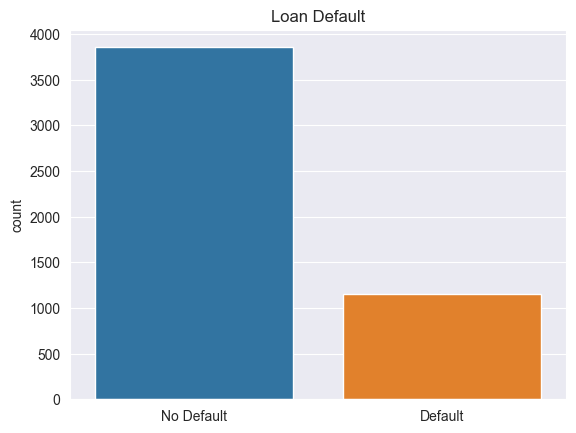

In [181]:
default_plot = sns.countplot(x='loan_default', data = loan)
plt.title("Loan Default")
plt.xticks(ticks=range(len([0,1])), labels=['No Default', 'Default'])
plt.xlabel('')

- We can that around 20-25 percent of all loans in the data set are defaults
- Due to the bias towards non-defaults, we need to consider resampling our dataset to create equal amount of each category.
- Using F1 score for deciding the success of a model would make sense.

#### Predictor Variables

##### **Plot distributions for numerical features**

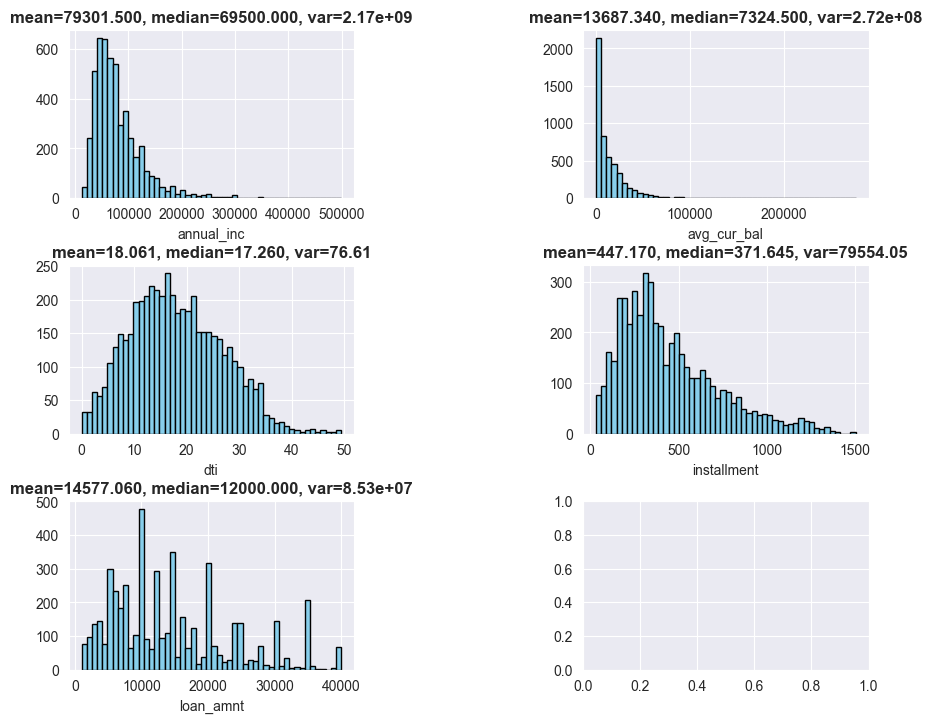

In [182]:
# create figure for numerical feature plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
# Iterate over each data column and plot on each subplot using a for loop

for i, (col, ax) in enumerate(zip(feature.select_dtypes(include=['float']).columns, axes.flatten())):
    mean = loan[col].mean()
    median = loan[col].median()
    var = loan[col].var().round(2)
    if var > 100000:
      var = "{:.2e}".format(var)

    ax.hist(loan[col], bins=50, color='skyblue', edgecolor='black')  # Adjust bins as needed
    ax.set_title(f"mean={mean:.3f}, median={median:.3f}, var={var}", fontweight='bold')
    ax.set_xlabel(col)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.8, hspace=0.4)

- The distributions of these variables are skewed due to their values being strictly positive.
- Will require a log transformation

#### **Focus: Annual Income**


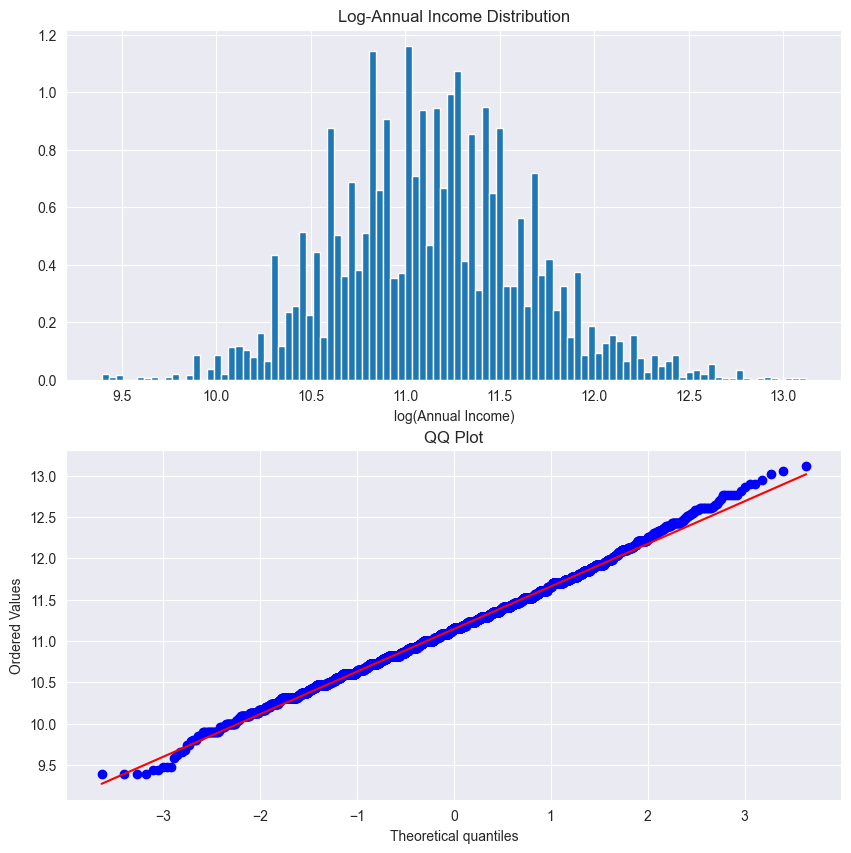

In [183]:
import numpy as np
import seaborn as sns

loan['annual_inc_log'] = np.log(loan.annual_inc)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot histogram on the first subplot
axs[0].hist(loan['annual_inc_log'], bins=100, density=True)
axs[0].set_title("Log-Annual Income Distribution")
axs[0].set_xlabel("log(Annual Income)")

# Plot QQ plot on the second subplot
from scipy import stats
stats.probplot(loan['annual_inc_log'], dist="norm", plot=axs[1])
axs[1].set_title('QQ Plot')

plt.show()

- We can now see a more normally distribution of the annual income

##### **Plot distributions for categorical variables**

In [184]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_default'], margins=True)
    ct_res['Defaulted(%)'] = round( ct_res[1]/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

This is a contigency table to see the relationship between the categorical variables.

**Looking at employment length (Behavioural Factor)**

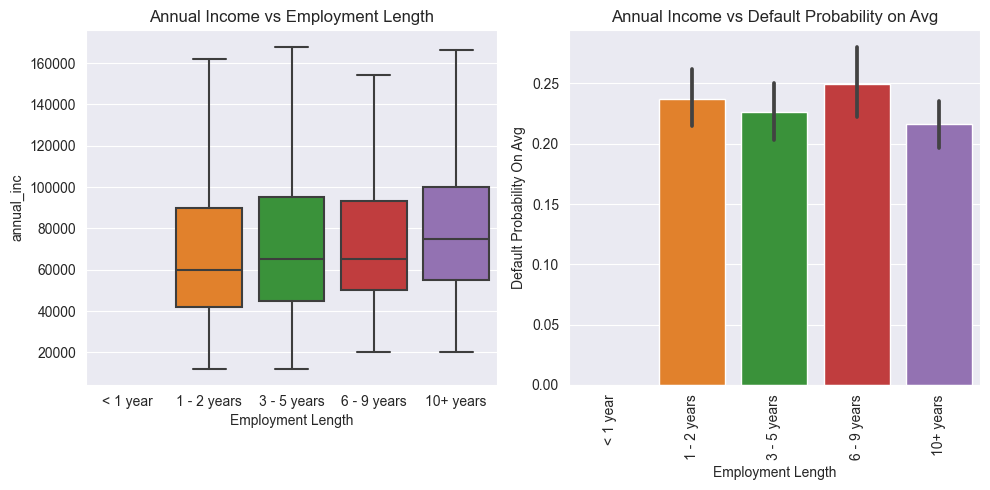

In [185]:
mean_default_prob = loan.groupby("emp_length_cat")["loan_default"].mean().reset_index()
mean_default_prob = mean_default_prob.sort_values(by="loan_default", ascending=False)

# Create subplots
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, sharey= False)

# Boxplot on the first subplot
sns.boxplot(x='emp_length_cat', y='annual_inc', data=loan, showfliers=False, order= emp_length_unique_list, ax=ax1)
ax1.set_title("Annual Income vs Employment Length")
ax1.set_xlabel("Employment Length")

# Bar plot on the second subplot
sns.barplot(x='emp_length_cat', y='loan_default', data=loan , order = emp_length_unique_list, ax=ax2)
ax2.set_title("Annual Income vs Default Probability on Avg")
ax2.set_xlabel("Employment Length")
# Set y-label for the bar plot
ax2.set_ylabel("Default Probability On Avg")

# Rotate x-axis labels for better readability
ax2.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

We can see that there is an increase with employment length and their annual income. However, when taking in the average probability for defaulting, there is no clear relationship with defaulting.

In [186]:
get_ct(loan, 'emp_length')

loan_default,0,1,Defaulted(%)
emp_length,,,
1,932,290,23.73
2,871,255,22.65
3,646,215,24.97
4,1404,387,21.61
All,3853,1147,22.94


- Interesting aspect in this situation is that there is no data for < 1 year of employment length

**Home Ownership (Behavioural Factor)**

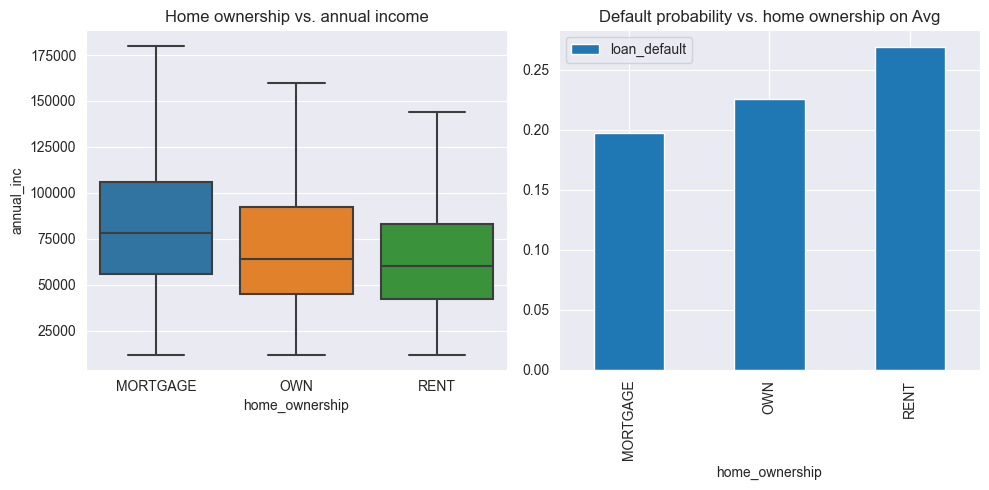

In [187]:
fig, (ax1, ax2) = plt.subplots(figsize = (10,5), ncols=2, sharey= False)
sns.boxplot(x="home_ownership",y="annual_inc", data = loan, showfliers=False, ax = ax1) #showfliers=False for nice display
ax1.set_title("Home ownership vs. annual income")
loan[["home_ownership",'loan_default']].groupby("home_ownership").mean().plot.bar(rot=90,ax = ax2)
plt.title("Default probability vs. home ownership on Avg");

# Adjust layout
plt.tight_layout()

- As suspected, annual income for people who rent tend to be lower than people who own or take a mortgage, and their probabilility of defaulting is the highest.
- This could play as a beneficial factor when determining a behavioural factor for deciding our model.

In [188]:
get_ct(loan, 'home_ownership')

loan_default,0,1,Defaulted(%)
home_ownership,,,
MORTGAGE,1945,479,19.76
OWN,466,136,22.59
RENT,1442,532,26.95
All,3853,1147,22.94


### Bivariate Analysis

#### **Marginal distribution of Default Status based on Log-Annual Income**

Text(0.5, 1.0, 'Annual Income -- Loan Status')

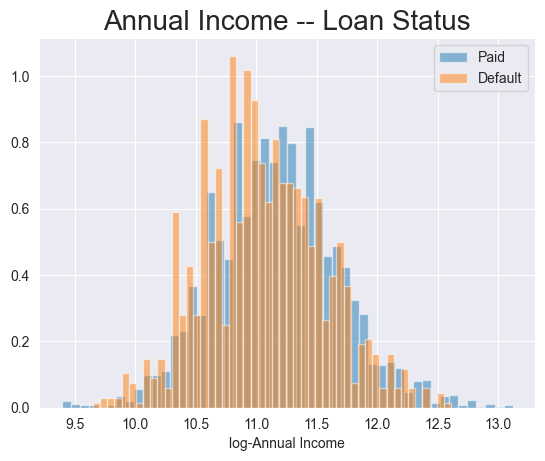

In [189]:
loan['annual_inc_log'][loan.loan_default == 0].hist(bins=50, density=True, alpha=0.5, label="Paid")
loan['annual_inc_log'][loan.loan_default == 1].hist(bins=50, density=True, alpha=0.5, label="Default")
plt.xlabel("log-Annual Income")
plt.legend()
plt.title("Annual Income -- Loan Status", fontsize=20)

- We can see that the distribution for both the groups in terms of their annual income are similarly distributed.
- This can indicate that income is not likely to explain the difference in loan status.

#### **Annual Income & Monthly Installments**

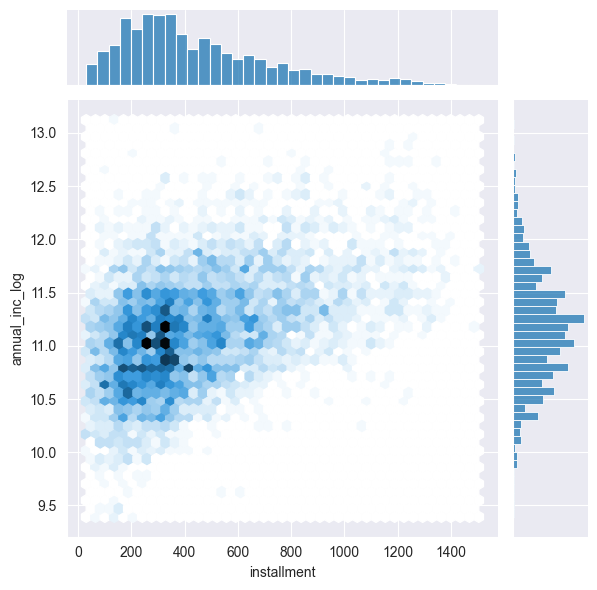

In [190]:
sns.jointplot(data = loan, x = 'installment', y = 'annual_inc_log', kind="hex")

- As mentioned previously, the installment predictor is skewed positively. We will need it to undergo a log transformation

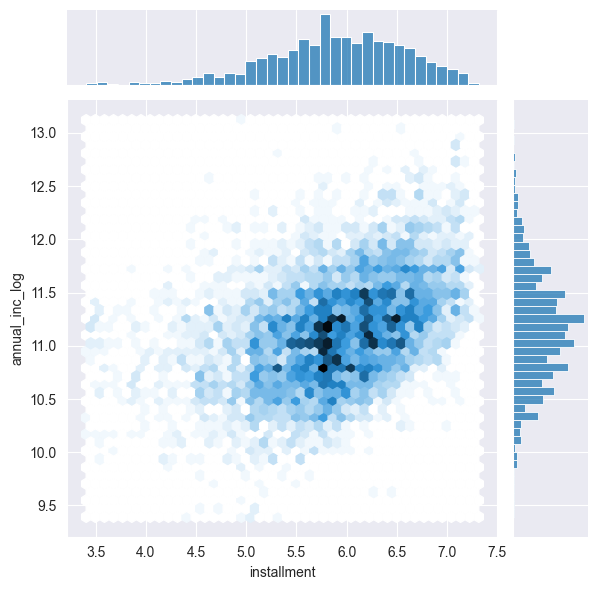

In [191]:
sns.jointplot(data = loan, x = np.log(loan.installment), y = 'annual_inc_log', kind="hex")

- We can see that there is a more linear relationship between these 2 variables, with a few outliers on the far left.

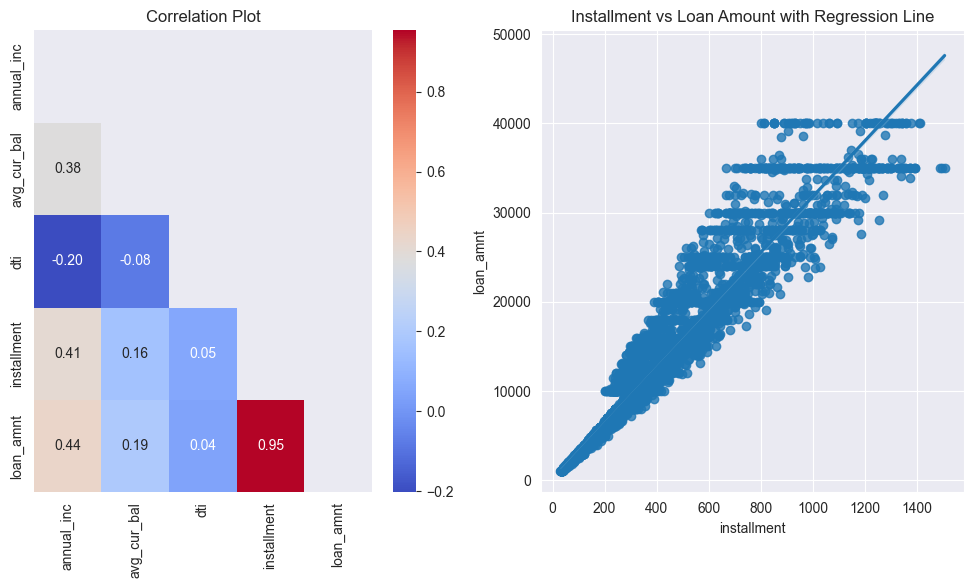

<Figure size 1000x800 with 0 Axes>

In [192]:
# Create a correlation plot to see how each pair of variables relate to one another.
# Compute the correlation matrix.
corr_matrix = loan[feature.select_dtypes(include=['float']).columns].corr()
# Create a mask to hide the upper triangle of our corrplot
mask = np.triu(np.ones_like(corr_matrix))

# Plotting the heatmap for correlation.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask = mask, ax=axes[0])
sns.regplot(x = 'installment', y = 'loan_amnt', data = loan, ax=axes[1])

# Set titles
axes[0].set_title('Correlation Plot')
axes[1].set_title('Installment vs Loan Amount with Regression Line')

axes[1].set_xlabel('installment')
axes[1].set_ylabel('loan_amnt')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


Correlation is huge for "installment" and "loan_amnt", which means the monthly payment owed by the borrower and the listed amount of the loan applied for by the borrower has a strong correlation. This is reasonable given a borrower needs to pay back more per month their debt back if the debt amount is huge.

Since "installment" and "loan amount" are so closely related, we need to check if they have a linear relationship. If colinearity exists, then we should ignore one of them.

For this analysis we will drop the loan_amnt variable as installment will play a major role as a factor in our hypothesis.

In [193]:
loan = loan.drop('loan_amnt', axis = 1)

### Missing Values Treatment

In [194]:
#Missing value treatment
# checking missing values
loan.isnull().sum()

annual_inc                  0
application_type            0
avg_cur_bal                 0
chargeoff_within_12_mths    0
delinq_2yrs                 0
dti                         0
emp_length                  0
grade                       0
inq_last_12m                0
installment                 0
num_actv_bc_tl              0
pub_rec_bankruptcies        0
home_ownership              0
term                        0
mort_acc                    0
num_tl_90g_dpd_24m          0
purpose                     0
loan_default                0
job                         0
emp_length_cat              0
annual_inc_log              0
dtype: int64

There are no missing values in any of our variables.

### Outlier Treatment

In [195]:
def outlier_check(column):
  # Specify the numerical columns for outlier detection
  numerical_columns = loan.select_dtypes(include=['float64']).columns

  # Calculate the IQR for each numerical column
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1

  # Identify outliers
  outliers = ((loan[numerical_columns] < (Q1 - 1.5 * IQR)) | (loan[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
  #return outliers[outliers == True]
  return loan[outliers]

# Generate a list of numerical columns
numerical_columns = loan.select_dtypes(include=['float64']).columns

# Calculate an array of IQR for each numerical column
Q1 = loan[numerical_columns].quantile(0.25)
Q3 = loan[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((loan[numerical_columns] < (Q1 - 1.5 * IQR)) | (loan[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Display the outliers
loan[outliers][numerical_columns]

,annual_inc,avg_cur_bal,dti,installment,annual_inc_log
34,79000.0,4088.0,22.14,1327.45,11.277203
35,52000.0,51655.0,15.94,184.35,10.858999
38,185000.0,21735.0,4.09,402.08,12.128111
39,400000.0,64556.0,10.07,1174.91,12.899220
46,125000.0,4246.0,15.31,1335.70,11.736069
...,...,...,...,...,...
4948,96000.0,91931.0,8.24,285.71,11.472103
4950,173000.0,20760.0,28.22,287.44,12.061047
4959,15000.0,1960.0,34.86,171.11,9.615805
4962,85000.0,44945.0,13.53,125.30,11.350407


- As we can see there are about 621 data points that contain outlier data.
- For now we will leave the data how it is, and in the future decide what best to do with these outliers.

### Variable Transformation/Creation

#### **Yearly Installment Income**

- The yearly paymnt owed by the borrower, as a fraction of annual income, is a standard metric used in evaluating whether a loan should be issued.
- We create a new variable that calculates this using the installment variable and annual income

Text(0.5, 0, 'Installment / Income')

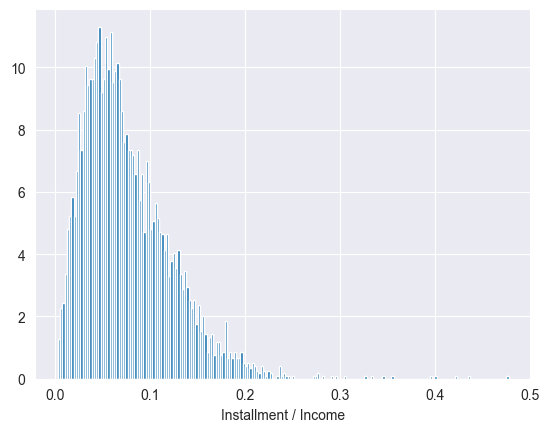

In [196]:
loan['install_income'] = 12 * loan.installment / loan.annual_inc
H = plt.hist(loan['install_income'], bins=200, density=True)
plt.xlabel(r"Installment / Income")

- Quite clearly, we see the distribution is positively skewed, it will need a transformation when we would like to test for significance.

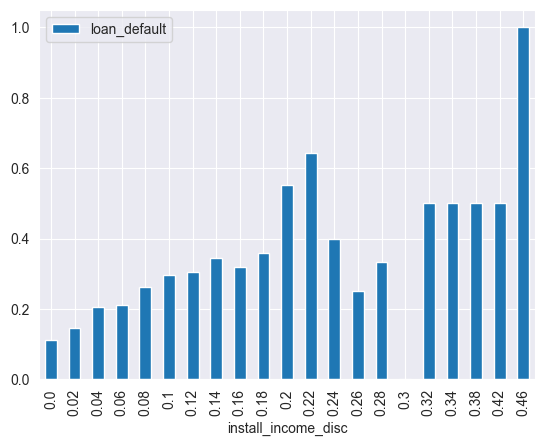

In [197]:
# let us discretize the "install_income" variable to study the probability of default
# as a function of "install_income"
loan["install_income_disc"] = (loan.install_income*50).astype(int)/50.  #discretization
loan[["loan_default", "install_income_disc"]].groupby("install_income_disc").mean().plot.bar(rot=90)
loan = loan.drop(["install_income_disc"], axis=1)

- There is a clear positive association: as the fraction of the annual income devoted to the re-imbursement of the loan increases, the probability of default sharply increases

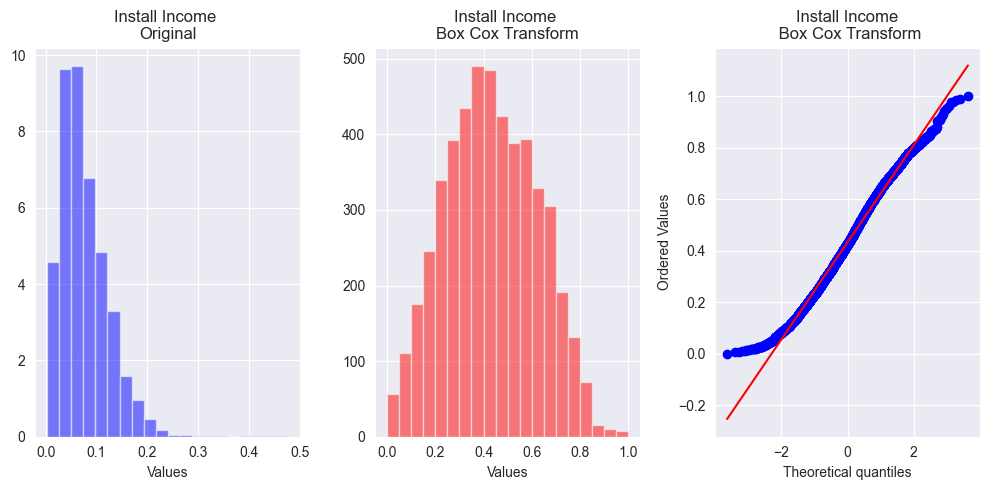

In [198]:
# Here we are going to transform our new variable using the box cox method in order for it to be normally distributed. Reason for using box cox method was to avoid using log transformation due to the values being between 0 and 0.5 due to it being a ratio.
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
transformed_data, _ = boxcox(loan['install_income'] + 1)
# Scale the transformed data to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
transformed_data_scaled = scaler.fit_transform(transformed_data.reshape(-1, 1)).flatten()

# Plot histograms of original and transformed data
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(loan.install_income, bins=20, color='blue', alpha=0.5, density= True)
plt.title('Install Income \nOriginal')
plt.xlabel('Values')

plt.subplot(1, 3, 2)
plt.hist(transformed_data_scaled, bins=20, color='red', alpha=0.5)
plt.title('Install Income \nBox Cox Transform')
plt.xlabel('Values')

plt.subplot(1, 3, 3)
stats.probplot(transformed_data_scaled, dist="norm", plot= plt)
plt.title("Install Income\n Box Cox Transform")

# Adjust layout
plt.tight_layout()

plt.show()

# Adding this variable to our loan data
loan['install_income_norm'] = transformed_data_scaled

We want to assess whether there is a signficance of the install_income with respect to loan_default parameter using the t test.

$ \mu_1$ is the mean of install income given that they have not defaulted
$ \mu_2$ is the mean of install income given that they have defaulted
$$ H_0: \mu_1=\mu_2$$
$$H_a: \mu_1 \neq \mu_2$$

In [199]:
from scipy.stats import ttest_ind
binary_categorical_variable = loan['loan_default']
transformed_data = loan['install_income_norm']

# Perform t-test for independent samples
t_statistic, p_value = ttest_ind(transformed_data[binary_categorical_variable == 0],
                                  transformed_data[binary_categorical_variable == 1])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -12.482459955482879
P-value: 3.105367751892538e-35


Based on the statistical test above, we can **reject the null hypothesis**. We can definitely see there is huge difference in means resulting in high correlation between them.

#### Categorical Variables Dummy Creation & Ordinal Variable (employment length)

Recall our categorical variables:
- application_type
- home_ownership
    - Behavioural factor
- purpose
- job
    - Behavioural factor

We might have issues when looking at job and purpose as a categorical variable due to how many unique items there are.

Approaches:

1. For Purpose, we can check the frequency of each purpose and determine whether we can bin these to another categorical variable.
2. For Job, it is best to creating some level of discrete values in one column. We do this by looking at the count of each variable and then setting it as the value.

Advantages:
1. It is very simple to implement
2. Does not increase the feature dimensional space

Disadvantages:
1. If some labels have the same count, then they will be replaced with the same count and they will loose some valuable information.
2. Adds somewhat arbitrary numbers, and therefore weights to the different labels, that may not be related to their predictive power.



#### FOCUSING ON PURPOSE AND JOBS (SINCE THEY HAVE THE MOST CATEGORIES)

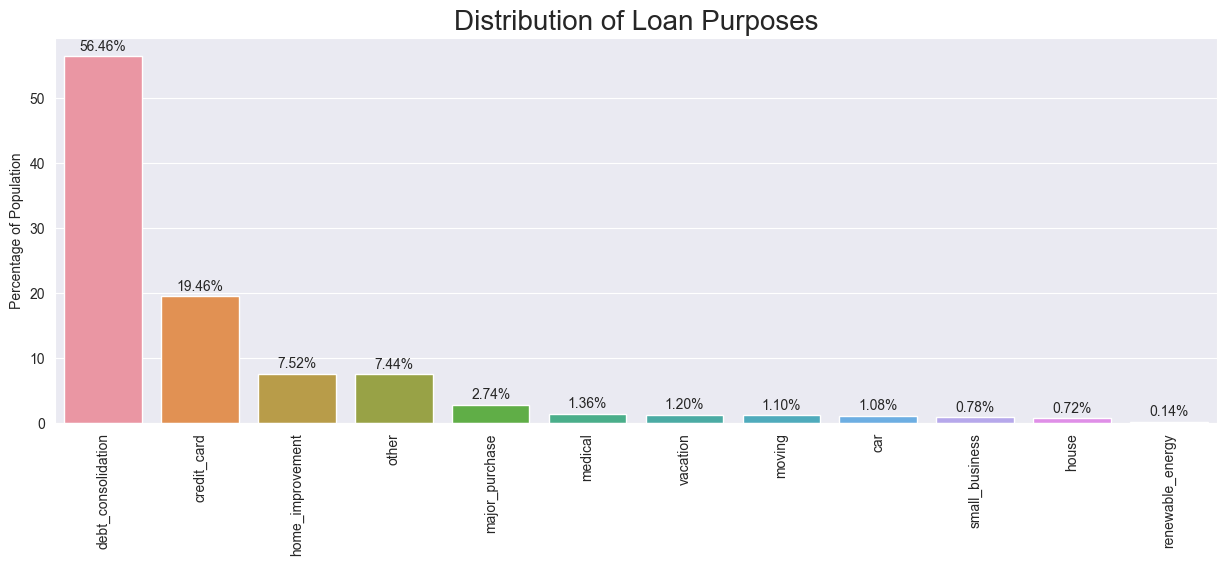

In [200]:
plt.figure(figsize= (15,5))
purp = loan['purpose']
ax = sns.barplot(x=list(purp.value_counts().index.values),
            y=100 * purp.value_counts().values / len(purp),
            orient="v",
            )

counts = purp.value_counts()
total_obs = len(purp)
percentage = (counts / total_obs) * 100
percentages_sorted = percentage.sort_values(ascending=False)

for i, percentage in enumerate(percentages_sorted):
    ax.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Loan Purposes", fontsize=20);

<Figure size 1500x1000 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

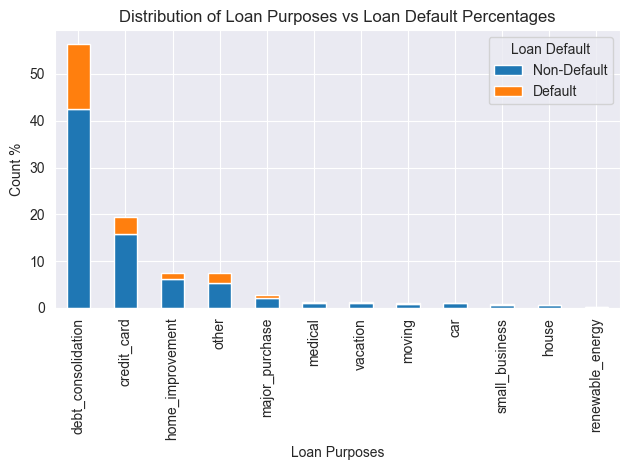

In [201]:
plt.figure(figsize= (15,10))
unstacked_df = loan.groupby(['purpose', 'loan_default']).size().unstack()
unstacked_df[0] = unstacked_df[0] / len(loan) *100
unstacked_df[1] = unstacked_df[1] / len(loan) *100
sorted_df = unstacked_df.sum(axis=1).sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
unstacked_df.loc[sorted_df].plot(kind='bar', stacked=True)
plt.title('Distribution of Loan Purposes vs Loan Default Percentages')
plt.xlabel('Loan Purposes')
plt.ylabel('Count %')
plt.xticks(rotation=90)
plt.legend(title='Loan Default', labels=['Non-Default', 'Default'])
plt.tight_layout()
plt.show()

Based on the above plot, we can see that most of the data belongs to debt_consolidation. I would reccomend that we reduce the dimensionality by anything below 1%of the sample population be joined into the other category.

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/gk/0ymk45sn09j5z5hxlqhg03yc0000gn/T/ipykernel_10556/1268816030.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif purpose is 'credit_card':


Text(0.5, 1.0, 'Distribution of Loan Purposes')

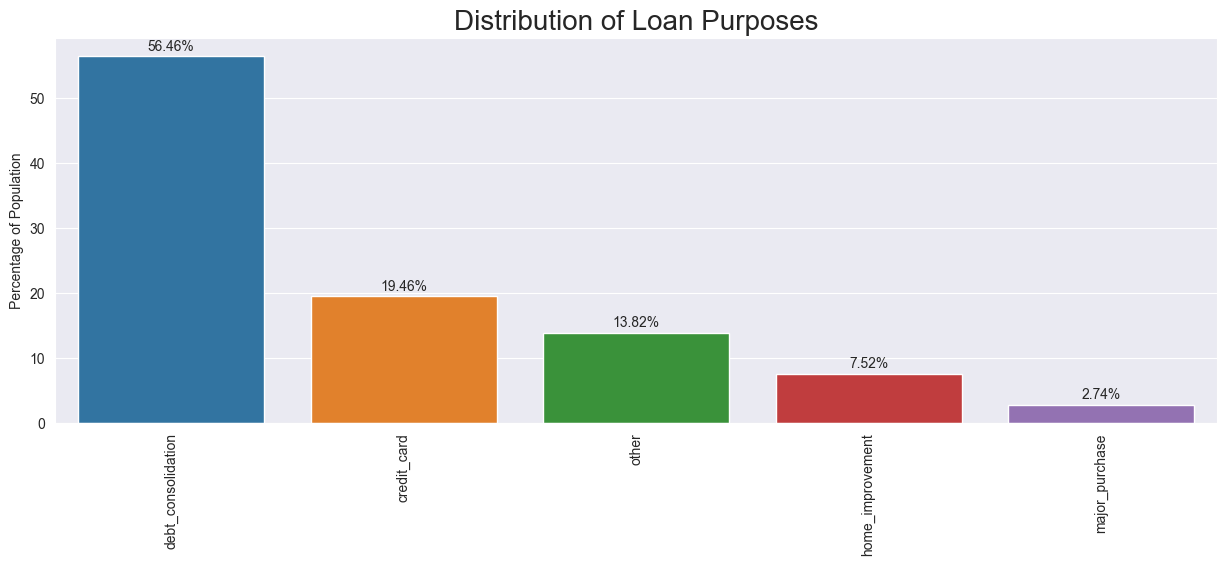

In [202]:
# Loop through the DataFrame and rename loan purposes
for i, purpose in enumerate(loan['purpose']):
    if purpose in list(purp.value_counts().index.values[5:]):
        loan.at[i, 'purpose'] = 'other'
    elif purpose is 'credit_card':
        loan.at[i, 'purpose'] = 'other'

loan['purpose'] = pd.Categorical(loan['purpose'],
                                        categories= ['debt_consolidation', 'credit_card', 'home_improvement', 'other', 'major_purchase'],
                                        ordered = False)
plt.figure(figsize= (15,5))
cat = loan['purpose']
ax = sns.barplot(x=list(cat.value_counts().index.values),
                 y=100 * cat.value_counts().values / len(loan),
                 orient="v",
                 )

counts = cat.value_counts()
total_obs = len(cat)
percentage = (counts / total_obs) * 100
percentages_sorted = percentage.sort_values(ascending=False)

for i, percentage in enumerate(percentages_sorted):
    ax.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Loan Purposes", fontsize=20)

<Figure size 1500x1000 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

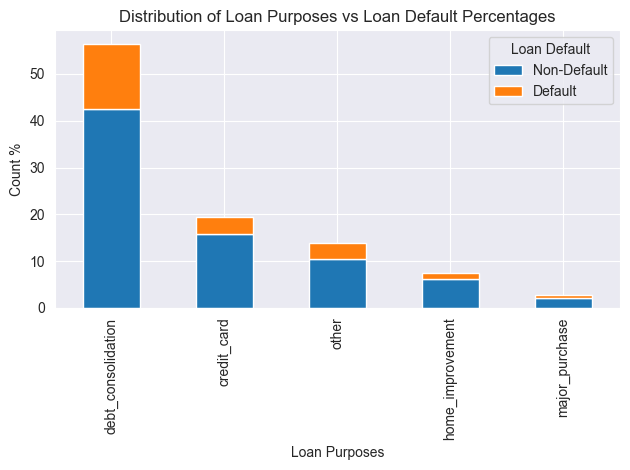

In [203]:
plt.figure(figsize= (15,10))
unstacked_df = loan.groupby(['purpose', 'loan_default']).size().unstack()
unstacked_df[0] = unstacked_df[0] / len(loan) *100
unstacked_df[1] = unstacked_df[1] / len(loan) *100
sorted_df = unstacked_df.sum(axis=1).sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
unstacked_df.loc[sorted_df].plot(kind='bar', stacked=True)
plt.title('Distribution of Loan Purposes vs Loan Default Percentages')
plt.xlabel('Loan Purposes')
plt.ylabel('Count %')
plt.xticks(rotation=90)
plt.legend(title='Loan Default', labels=['Non-Default', 'Default'])
plt.tight_layout()
plt.show()

In [204]:
# # Loop through the DataFrame and rename loan purposes
# for i, purpose in enumerate(categorical['purpose']):
#     if purpose in list(purp.value_counts().index.values[5:]):
#         categorical.at[i, 'purpose'] = 'other'
#     elif purpose is 'credit_card':
#         categorical.at[i, 'purpose'] = 'other'
#
# categorical['purpose'] = pd.Categorical(categorical['purpose'],
#                                         categories= ['debt_consolidation', 'other'],
#                                         ordered = False)
# plt.figure(figsize= (15,5))
# cat = categorical['purpose']
# ax = sns.barplot(x=list(cat.value_counts().index.values),
#                  y=100 * cat.value_counts().values / len(categorical),
#                  orient="v",
#                  )
#
# counts = cat.value_counts()
# total_obs = len(cat)
# percentage = (counts / total_obs) * 100
# percentages_sorted = percentage.sort_values(ascending=False)
#
# for i, percentage in enumerate(percentages_sorted):
#     ax.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')
#
# plt.xticks(rotation=90)
# plt.ylabel("Percentage of Population")
# plt.title("Distribution of Loan Purposes", fontsize=20);

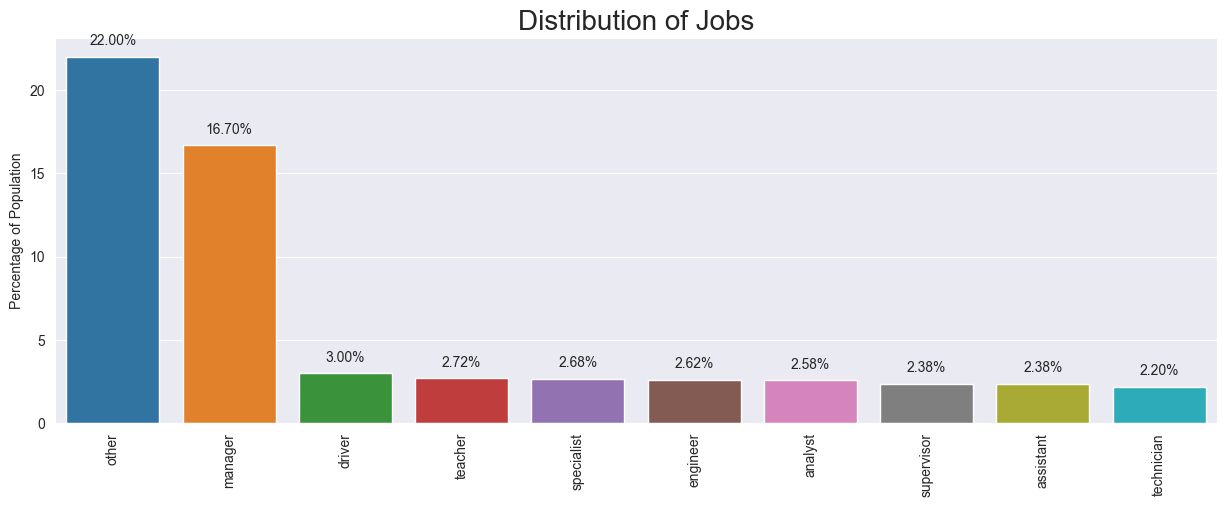

In [205]:
plt.figure(figsize= (15,5))
ax = sns.barplot(x=list(loan["job"].value_counts()[:10].index.values),
            y=100 * loan.job.value_counts()[:10].values / len(loan),
            orient="v",
            )

counts = loan['job'].value_counts()[:10]
total_obs = len(loan['job'])
percentage = (counts / total_obs) * 100
percentages_sorted = percentage.sort_values(ascending=False)

for i, percentage in enumerate(percentages_sorted):
    ax.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.ylabel("Percentage of Population")
plt.title("Distribution of Jobs", fontsize=20);

In [206]:
# Obtain the counts of each unique labels and store them as a dict which will be used to re-map the labels
jobs_frequency_map = loan.job.value_counts().to_dict()
loan.job = loan.job.map(jobs_frequency_map)

#display output
loan.job.head()

0      18
1    1100
2     129
3    1100
4     150
Name: job, dtype: int64

In [207]:
# Create and Update to categorical data
cat_purpose          = pd.get_dummies(loan['purpose'], prefix= 'purpose', drop_first= True)
cat_application_type = pd.get_dummies(loan['application_type'], prefix= 'app_type', drop_first= True)
cat_home_ownership   = pd.get_dummies(loan['home_ownership'], prefix= 'home_own', drop_first= True)
loan = pd.concat([loan, cat_purpose], axis= 1)
loan = pd.concat([loan, cat_application_type], axis= 1)
loan = pd.concat([loan, cat_home_ownership], axis= 1)

# Remove unnecessary variables, that will not be used for the model
loan2 = loan.drop(['purpose',
                   'application_type',
                   'home_ownership',
                   'emp_length_cat',
                   'annual_inc',
                   'annual_inc_log',
                   'installment',
                   'install_income'], axis = 1)

In [208]:
loan2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   avg_cur_bal               5000 non-null   float64
 1   chargeoff_within_12_mths  5000 non-null   int64  
 2   delinq_2yrs               5000 non-null   int64  
 3   dti                       5000 non-null   float64
 4   emp_length                5000 non-null   int64  
 5   grade                     5000 non-null   int64  
 6   inq_last_12m              5000 non-null   int64  
 7   num_actv_bc_tl            5000 non-null   int64  
 8   pub_rec_bankruptcies      5000 non-null   int64  
 9   term                      5000 non-null   int64  
 10  mort_acc                  5000 non-null   int64  
 11  num_tl_90g_dpd_24m        5000 non-null   int64  
 12  loan_default              5000 non-null   int64  
 13  job                       5000 non-null   int64  
 14  install_

## Re-Sampling Technique

In [209]:
df = loan2.copy()
print('Loan Default class percentages:')
class_percentage = df['loan_default'].value_counts(normalize=True) * 100
print(class_percentage)
print(df.loan_default.value_counts())

Loan Default class percentages:
0    77.06
1    22.94
Name: loan_default, dtype: float64
0    3853
1    1147
Name: loan_default, dtype: int64


In [210]:
from sklearn.model_selection import train_test_split
# we will use a 70%/30% split for training/validation
cut_off = 0.7
n_train = int(cut_off*len(df))

df_test=df[n_train:]
df_train=df[:n_train]

X_train = df_train.drop('loan_default', axis=1)
Y_train = df_train['loan_default']

X_test = df_test.drop('loan_default', axis=1)
Y_test = df_test['loan_default']

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3500, 21), (3500,), (1500, 21), (1500,))

In [217]:
# Building a logistic model to test the up-sampling
def logModel_testing(X_train, Y_train, X_test, Y_test):
    from sklearn.linear_model import LogisticRegression
    logistic_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear').fit(X_train,Y_train)
    y_pred = logistic_model.predict(X_test)

    # Print Summary of Model
    from statsmodels.api import Logit

    # Use statsmodels to print summary
    logit_model = Logit(Y_train, X_train)
    result = logit_model.fit()
    print(result.summary())

    # Classification Metrics
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    print("accuracy_score : ", acc)
    print("precision_score : ", prec)
    print("recall_score : ", recall)
    print("f1_score : ", f1)
    target_names = ['class 0', 'class 1']
    print(classification_report(Y_test, y_pred, target_names=target_names))



    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    cf_matrix=confusion_matrix(y_pred,Y_test)
    dis = ConfusionMatrixDisplay(
        confusion_matrix= cf_matrix
    )

    dis.plot(cmap=plt.cm.Blues)

    plt.show()

#### Without Any Resampling

Optimization terminated successfully.
         Current function value: 0.487977
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           loan_default   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3479
Method:                           MLE   Df Model:                           20
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                 0.09915
Time:                        12:12:12   Log-Likelihood:                -1707.9
converged:                       True   LL-Null:                       -1895.9
Covariance Type:            nonrobust   LLR p-value:                 1.971e-67
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
avg_cur_bal               -8.27e-06   3.83e-06     -2.162      0.031   -1.58e-05

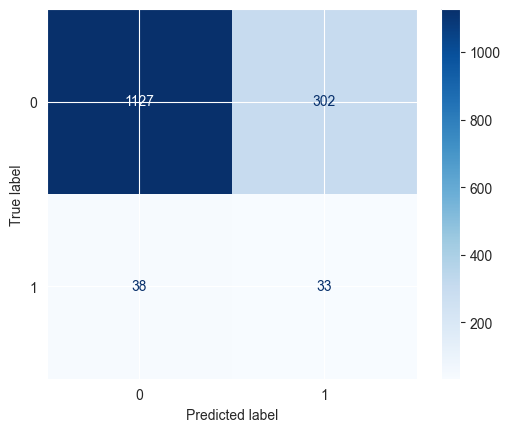

In [218]:
logModel_testing(X_train, Y_train, X_test, Y_test)

### Method 1: Up and Down Sampling

#### UP Sampling

In [158]:
# Separating majority and minority for Loan Default (dependent var.)
df_majority = df_train[df_train['loan_default']==0]
df_minority = df_train[df_train['loan_default']==1]

from sklearn.utils import resample

df_minority_upsampled = resample(df_minority,
                                 replace= True,
                                 n_samples= len(df_majority),
                                 random_state= 1)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = df_upsampled.sample(frac = 1) # Reshuffling our training data

# Dividing training with target variable and predictors
X_up = df_upsampled.drop('loan_default', axis=1)
Y_up = df_upsampled['loan_default']

X_up.shape, X_test.shape, Y_up.shape, Y_test.shape

((5376, 21), (1500, 21), (5376,), (1500,))

accuracy_score :  0.6373333333333333
precision_score :  0.3213675213675214
recall_score :  0.5611940298507463
f1_score :  0.40869565217391307
              precision    recall  f1-score   support

     class 0       0.84      0.66      0.74      1165
     class 1       0.32      0.56      0.41       335

    accuracy                           0.64      1500
   macro avg       0.58      0.61      0.57      1500
weighted avg       0.72      0.64      0.66      1500



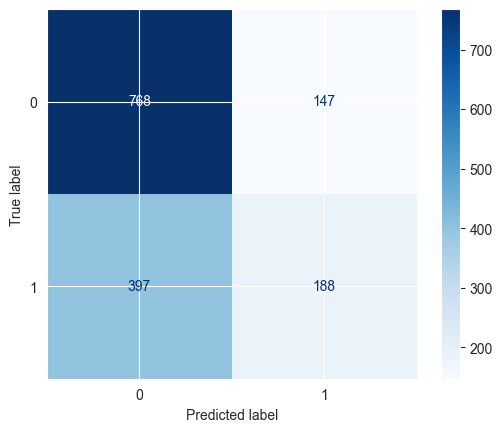

In [159]:
logModel_testing(X_up, Y_up, X_test, Y_test)

#### DOWN Sampling

In [160]:
df_majority_downsampled = resample(df_majority,
                                   replace=True,    # sample without replacement
                                   n_samples = len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled = df_downsampled.sample(frac=1)

# Dividing training with target variable and predictors
X_down = df_downsampled.drop('loan_default', axis=1)
Y_down = df_downsampled['loan_default']

X_down.shape, X_test.shape, Y_down.shape, Y_test.shape

((1624, 21), (1500, 21), (1624,), (1500,))

accuracy_score :  0.6406666666666667
precision_score :  0.33495145631067963
recall_score :  0.6179104477611941
f1_score :  0.43441762854144805
              precision    recall  f1-score   support

     class 0       0.85      0.65      0.74      1165
     class 1       0.33      0.62      0.43       335

    accuracy                           0.64      1500
   macro avg       0.59      0.63      0.59      1500
weighted avg       0.74      0.64      0.67      1500



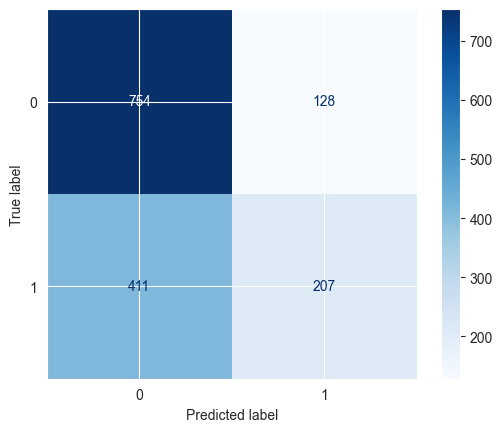

In [161]:
logModel_testing(X_down, Y_down, X_test, Y_test)

### Method 2: SMOTE

In [162]:
X_train_smote = df_train.drop('loan_default', axis=1)
Y_train_smote = df_train['loan_default']

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=2)
X_train_res, Y_train_res = smote.fit_resample(X_train_smote, Y_train_smote.ravel())

print(X_train_res.shape, Y_train_res.shape)
print("loan_default is 0:", len(Y_train_res[Y_train_res==0]), "\nloan_default is 1:", len(Y_train_res[Y_train_res==1]))

(5376, 21) (5376,)
loan_default is 0: 2688 
loan_default is 1: 2688


accuracy_score :  0.6593333333333333
precision_score :  0.3078602620087336
recall_score :  0.4208955223880597
f1_score :  0.35561160151324084
              precision    recall  f1-score   support

     class 0       0.81      0.73      0.77      1165
     class 1       0.31      0.42      0.36       335

    accuracy                           0.66      1500
   macro avg       0.56      0.57      0.56      1500
weighted avg       0.70      0.66      0.68      1500



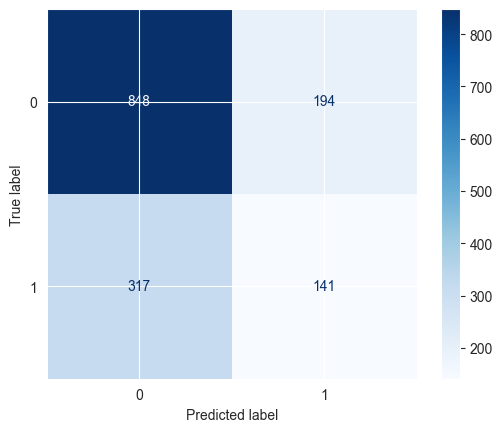

In [163]:
logModel_testing(X_train_res, Y_train_res, X_test, Y_test)

### Method 3: ADASYN

In [164]:
X_train_adasyn = df_train.drop('loan_default', axis=1)
Y_train_adasyn = df_train['loan_default']

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=2)
X_train_res, Y_train_res = adasyn.fit_resample(X_train_adasyn, Y_train_adasyn.ravel())

print(X_train_res.shape, Y_train_res.shape)
print("loan_default is 0:", len(Y_train_res[Y_train_res==0]), "\nloan_default is 1:", len(Y_train_res[Y_train_res==1]))

(5260, 21) (5260,)
loan_default is 0: 2688 
loan_default is 1: 2572


accuracy_score :  0.6706666666666666
precision_score :  0.31890660592255127
recall_score :  0.417910447761194
f1_score :  0.36175710594315247
              precision    recall  f1-score   support

     class 0       0.82      0.74      0.78      1165
     class 1       0.32      0.42      0.36       335

    accuracy                           0.67      1500
   macro avg       0.57      0.58      0.57      1500
weighted avg       0.71      0.67      0.69      1500



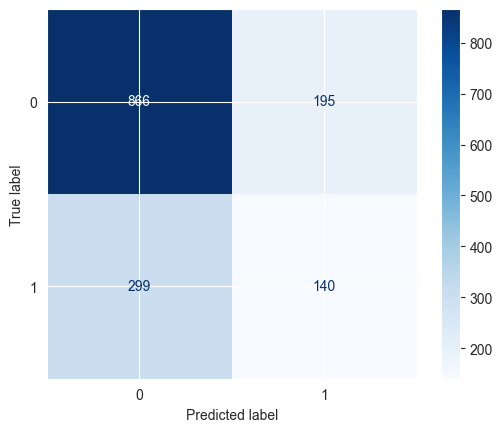

In [165]:
logModel_testing(X_train_res, Y_train_res, X_test, Y_test)

### Method 4: SMOTE & ENN

In [166]:
X_train_se = df_train.drop('loan_default', axis=1)
Y_train_se = df_train['loan_default']

from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=2)
X_train_res, Y_train_res = adasyn.fit_resample(X_train_se, Y_train_se.ravel())

print(X_train_res.shape, Y_train_res.shape)
print("loan_default is 0:", len(Y_train_res[Y_train_res==0]), "\nloan_default is 1:", len(Y_train_res[Y_train_res==1]))

(5260, 21) (5260,)
loan_default is 0: 2688 
loan_default is 1: 2572


accuracy_score :  0.6706666666666666
precision_score :  0.31890660592255127
recall_score :  0.417910447761194
f1_score :  0.36175710594315247
              precision    recall  f1-score   support

     class 0       0.82      0.74      0.78      1165
     class 1       0.32      0.42      0.36       335

    accuracy                           0.67      1500
   macro avg       0.57      0.58      0.57      1500
weighted avg       0.71      0.67      0.69      1500



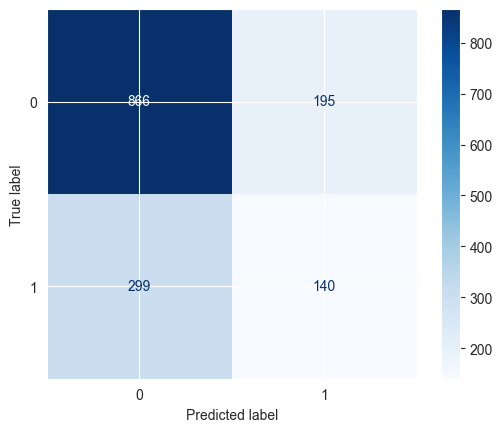

In [167]:
logModel_testing(X_train_res, Y_train_res, X_test, Y_test)

#### RESULTS FROM THE RESAMPLING:

| Resampling Technique |Loan Default Metric|        |          | Overall Model                                  |
|                      | Precision         | Recall | F1 Score | Accuracy     |Precision    | Recall | F1 Score |
|----------------------|-------------------|--------|----------|--------------|-------------|--------|----------|
| No Re-Sampling       | 0.46              | 0.10   | 0.16     | 0.777        | 0.46        | 0.09   | 0.163    |
| Up Sampling          | 0.32              | 0.57   | 0.41     | 0.639        | 0.32        | 0.56   | 0.412    |
| Down Sampling        | 0.34              | 0.63   | 0.44     | 0.642        | 0.33        | 0.63   | 0.438    |
| SMOTE                | 0.31              | 0.42   | 0.36     | 0.659        | 0.31        | 0.42   | 0.356    |
| ADASYN               | 0.32              | 0.42   | 0.36     | 0.671        | 0.32        | 0.42   | 0.362    |
| SMOTE & ENN          | 0.32              | 0.42   | 0.36     | 0.671        | 0.32        | 0.42   | 0.362    |




Based on the above table, I would recommend either using up sampling or down sampling.